In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import math
%matplotlib inline

In [2]:
df_baseline = pd.read_csv('baseline/summary.csv')
df_rewrite = pd.read_csv('rewrite/summary.csv')
keys = [
    'lut_used',
    'bram_used',
    'dsp_used',
    'reg_used',
    'lutmem_used',
    'uram_used',
    'runtime_avg'
]
benchmarks = set([
    "aes", "bfs-bulk", "bfs-queue", "fft-strided", "gemm-blocked", "gemm-ncubed", "kmp", "md-grid", "md-knn", 
    "nw", "sort-merge", "sort-radix", "spmv-crs", "spmv-ellpack", "stencil-stencil2d", "stencil-stencil3d",
])

In [3]:
df_baseline.sort_values(by='bench')

,status,dsp_used,uram_used,reg_used,lutmem_used,lut_used,bram_used,bench,runtime_avg,runtime_std
9,ok,0,0,17513,564,14603,2,baseline-runtime:machsuite-aes,0.792122,0.005694
4,ok,0,0,4520,133,2377,2,baseline-runtime:machsuite-bfs-bulk,2.380474,0.005620
14,ok,0,0,4506,136,2791,3,baseline-runtime:machsuite-bfs-queue,3.467180,0.010366
8,ok,38,0,8376,437,4291,2,baseline-runtime:machsuite-fft-strided,11.342940,0.008451
1,ok,11,0,8464,221,4468,2,baseline-runtime:machsuite-gemm-blocked,55.092090,0.006371
10,ok,11,0,28988,1182,16881,2,baseline-runtime:machsuite-gemm-ncubed,28.848180,0.018209
15,ok,0,0,3583,115,2164,1,baseline-runtime:machsuite-kmp,25.762540,0.007348
6,ok,41,0,19492,532,11106,8,baseline-runtime:machsuite-md-grid,13.159730,0.008965
3,ok,33,0,42472,539,29746,2,baseline-runtime:machsuite-md-knn,1.086350,0.010083
13,ok,0,0,6037,122,3970,1,baseline-runtime:machsuite-nw,11.241540,0.008060


In [4]:
def cleanup(df):
    # Remove prefix:machuite- from benchmark names
    df.bench = df.bench.apply(lambda row: row.split(':')[1].replace('machsuite-', ''))
    # Remove benchmarks with status != 'ok' 
    df = df[df.status == 'ok']

    return df

df_baseline = cleanup(df_baseline)
df_rewrite = cleanup(df_rewrite)
# Coerce columns to right types
df_baseline[keys] = df_baseline[keys].apply(pd.to_numeric)
df_rewrite[keys] = df_rewrite[keys].apply(pd.to_numeric)

In [5]:
# Find sets of missing benchmarks
baseline_missing = benchmarks.difference(set(df_baseline['bench']))
rewrite_missing = set(df_baseline.bench).difference(set(df_rewrite.bench))

In [6]:
df_baseline['type'] = 'baseline'
df_rewrite['type'] = 'rewrite'
df = pd.concat([df_baseline, df_rewrite], ignore_index=True, sort=False).sort_values(by='bench')

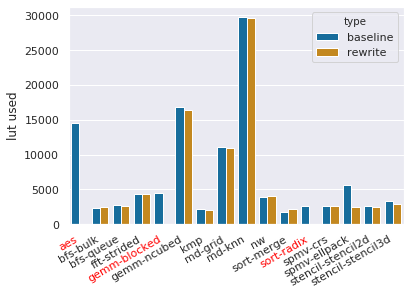

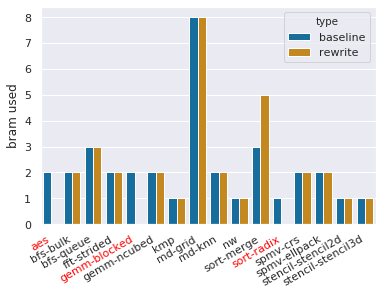

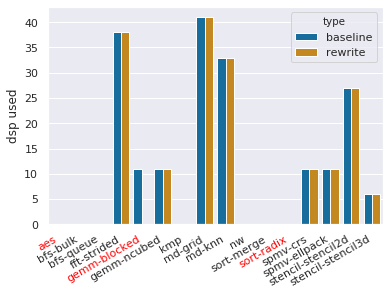

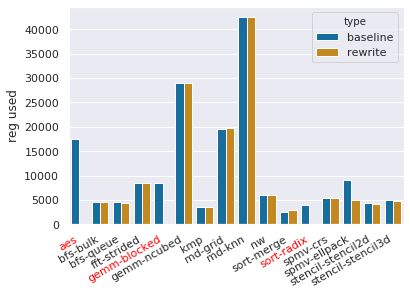

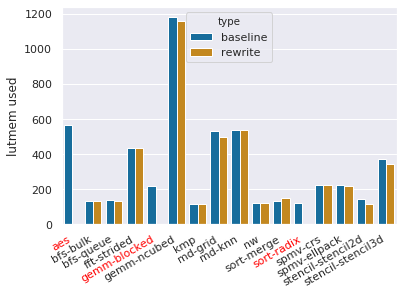

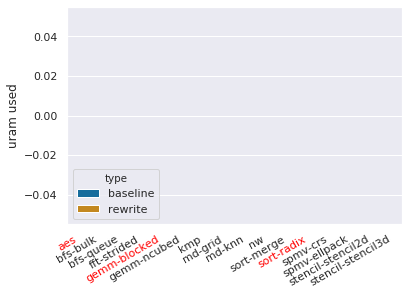

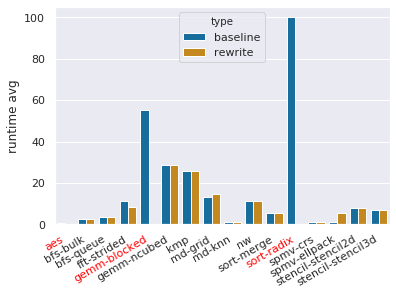

In [8]:
sns.set()

for idx, key in enumerate(keys):

    fig = plt.figure()
    ax = plt.gca()
    
    sns.barplot(x='bench', y=key, hue='type', data=df, palette='colorblind')
    
    plt.xticks(rotation=30, horizontalalignment='right')
    
    plt.xlabel('')
    plt.ylabel(f'{key}'.replace('_', ' '))
    
    [ t.set_color('red') for t in ax.xaxis.get_ticklabels() if t.get_text() in rewrite_missing ]
    
    fig.savefig('absolute-{}.pdf'.format(key.replace('_', '-')), dpi=200, bbox_inches = "tight")


In [7]:
for key in keys:
    df[key] = pd.to_numeric(df[key], errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29 entries, 9 to 0
Data columns (total 11 columns):
status         29 non-null object
dsp_used       29 non-null int64
uram_used      29 non-null int64
reg_used       29 non-null int64
lutmem_used    29 non-null int64
lut_used       29 non-null int64
bram_used      29 non-null int64
bench          29 non-null object
runtime_avg    29 non-null float64
runtime_std    29 non-null float64
type           29 non-null object
dtypes: float64(2), int64(6), object(3)
memory usage: 2.7+ KB


In [9]:
# Create join with baseline and rewrite data.
df_norm = df_rewrite.set_index('bench').join(df_baseline.set_index('bench'), lsuffix='_rewrite', rsuffix='_baseline')
for key in keys:
    df_norm[key] = df_norm[key + '_rewrite'] / df_norm[key + '_baseline']

df_norm.reset_index(inplace=True)
df_norm.fillna(value=0, inplace=True)
df_norm = df_norm.sort_values(by='bench')

In [12]:
df_norm

,bench,status_rewrite,bram_used_rewrite,lut_used_rewrite,lutmem_used_rewrite,uram_used_rewrite,reg_used_rewrite,dsp_used_rewrite,runtime_avg_rewrite,runtime_std_rewrite,...,runtime_avg_baseline,runtime_std_baseline,type_baseline,lut_used,bram_used,dsp_used,reg_used,lutmem_used,uram_used,runtime_avg
10,bfs-bulk,ok,2,2512,133,0,4577,0,2.380008,0.008386,...,2.380474,0.005620,baseline,1.056794,1.000000,0.0,1.012611,1.000000,0.0,0.999804
11,bfs-queue,ok,3,2553,135,0,4261,0,3.465871,0.007908,...,3.467180,0.010366,baseline,0.914726,1.000000,0.0,0.945628,0.992647,0.0,0.999622
12,fft-strided,ok,2,4311,437,0,8396,38,8.577651,0.006512,...,11.342940,0.008451,baseline,1.004661,1.000000,1.0,1.002388,1.000000,0.0,0.756211
6,gemm-ncubed,ok,2,16441,1162,0,28907,11,28.873040,0.010484,...,28.848180,0.018209,baseline,0.973935,1.000000,1.0,0.997206,0.983080,0.0,1.000862
4,kmp,ok,1,2118,115,0,3589,0,25.771470,0.013233,...,25.762540,0.007348,baseline,0.978743,1.000000,0.0,1.001675,1.000000,0.0,1.000347
2,md-grid,ok,8,10989,499,0,19648,41,14.842470,0.014941,...,13.159730,0.008965,baseline,0.989465,1.000000,1.0,1.008003,0.937970,0.0,1.127870
3,md-knn,ok,2,29652,539,0,42472,33,1.092930,0.008108,...,1.086350,0.010083,baseline,0.996840,1.000000,1.0,1.000000,1.000000,0.0,1.006057
9,nw,ok,1,4090,122,0,5976,0,11.184010,0.006584,...,11.241540,0.008060,baseline,1.030227,1.000000,0.0,0.989896,1.000000,0.0,0.994882
5,sort-merge,ok,5,2165,151,0,2931,0,5.480783,0.008173,...,5.494639,0.014721,baseline,1.260920,1.666667,0.0,1.119985,1.135338,0.0,0.997478
7,spmv-crs,ok,2,2646,226,0,5458,11,1.246405,0.008810,...,1.239944,0.007022,baseline,1.000000,1.000000,1.0,1.001652,1.000000,0.0,1.005211


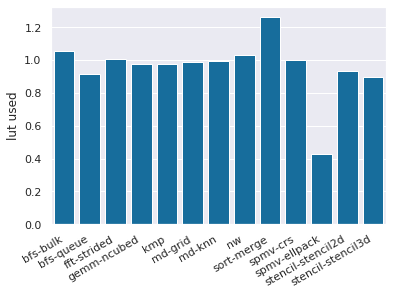

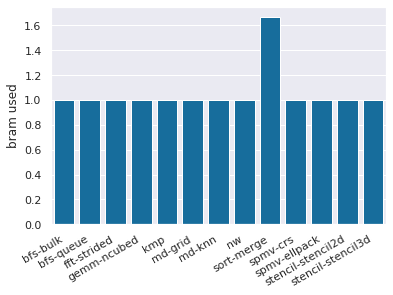

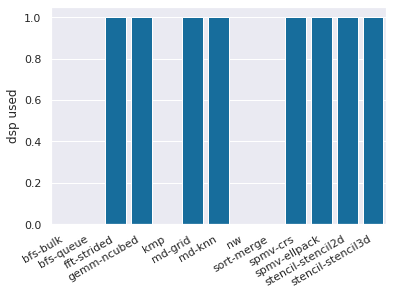

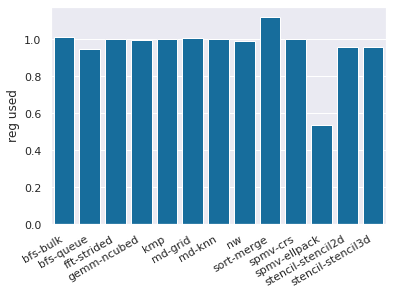

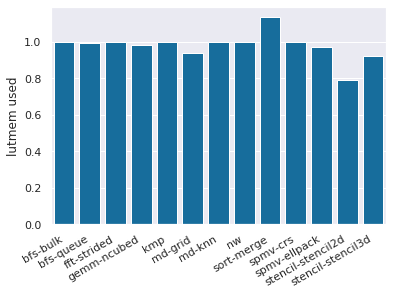

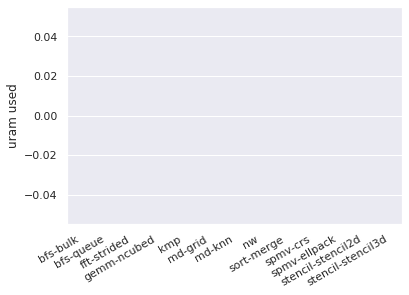

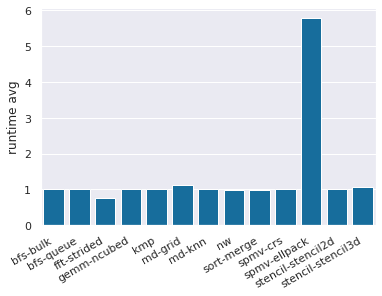

In [18]:
# plt.figure()
# sns.set()

# for key in keys:
#     plt.figure()
#     ax = plt.gca
#     sns.barplot(x='bench', y=key, data=df_norm, color=sns.color_palette()[0])
    
#     plt.xticks(rotation=30, horizontalalignment='right')
#     plt.savefig('normalized-{}.pdf'.format(key.replace('_','-')), dpi=200)
sns.set()

for idx, key in enumerate(keys):

    fig = plt.figure()
    ax = plt.gca()
    
    sns.barplot(x='bench', y=key, hue='type_baseline', data=df_norm, palette='colorblind')
    plt.xticks(rotation=30, horizontalalignment='right')
    
    plt.legend().set_visible(False)
    plt.xlabel('')
    plt.ylabel(f'{key}'.replace('_', ' '))
    
    [ t.set_color('red') for t in ax.xaxis.get_ticklabels() if t.get_text() in rewrite_missing ]
    
    fig.savefig('normalized-{}.pdf'.format(key.replace('_', '-')), dpi=200, bbox_inches = "tight")
